In [5]:
import kahnstatspy.GSLIB as GSLIB
import kahnstatspy.geostats as geostats
import numpy as np                                     
import pandas as pd   
import matplotlib.pyplot as plt   
from matplotlib.pyplot import cm 
from scipy.stats import linregress
%matplotlib inline

# Load UG90 Excel File

In [2]:
df = pd.read_csv("UG90 PROJECT.csv") #Create a data frame containing UG90 data called df

# Increasing the X and Y coordinates by 0.001
df_mod = df.copy()
df_mod['X'] = df['X'] + 0.001
df_mod['Y'] = df['Y'] + 0.001

# load Boundary Files

In [3]:
df_lease = pd.read_excel('lease Boundary.xlsx')
df_measured = pd.read_excel('UG2 measured.xlsx')

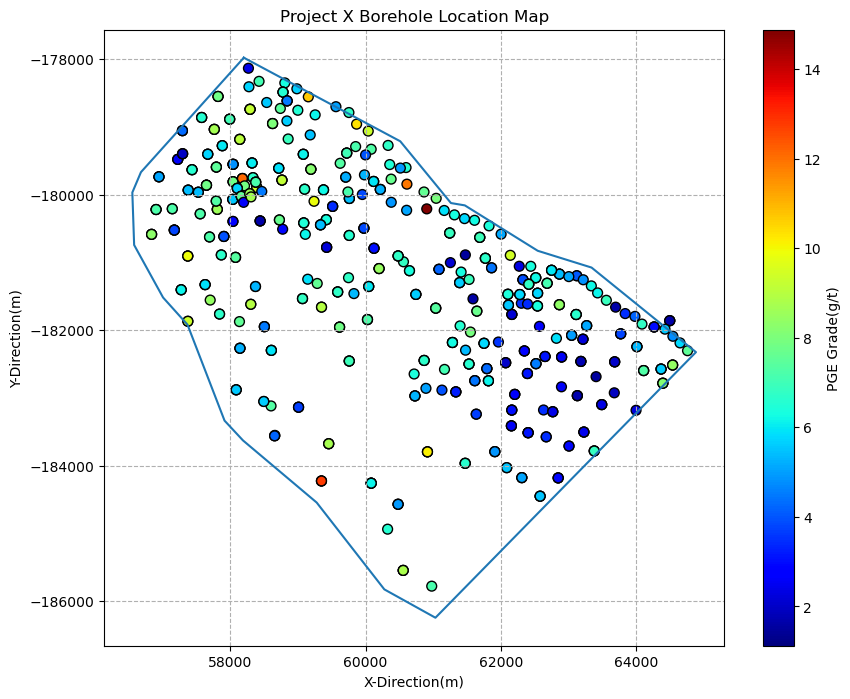

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(df_mod['X'], df_mod['Y'], c = df_mod['PGE'], s = 50, 
            edgecolors = 'black',cmap = 'jet')
cbar = plt.colorbar()
cbar.set_label("PGE Grade(g/t)", loc = 'center')
plt.title("Project X Borehole Location Map")
plt.xlabel("X-Direction(m)")
plt.ylabel("Y-Direction(m)")
plt.grid(linestyle = '--')
#plt.plot(df_lease['X'],df_lease['Y'])
plt.plot(df_measured['X'],df_measured['Y'])
plt.show()

# Execute Custom Functions

## Performance Metric

In [8]:
def calculate_performance_metric(predicted_results, cbb, kriging_variance, s, unest=-999.):
    """
    Calculate SLOR and KE based on kriging results and variance metrics.
    """
    # Calculate average kriging variance, excluding UNEST values
    valid_kriging_variance = kriging_variance[kriging_variance != unest]
    average_kv = np.mean(valid_kriging_variance) if valid_kriging_variance.size > 0 else np.nan

    # Assuming the last element of s is the Lagrange multiplier
    lambda_value = s[-1] if len(s) > 0 else np.nan

    # Calculate SLOR
    SLOR_denominator = cbb - average_kv + 2 * lambda_value
    SLOR = (cbb - average_kv + lambda_value) / SLOR_denominator if SLOR_denominator != 0 else np.nan

    # Calculate KE
    KE =  (cbb - average_kv)/cbb if cbb != 0 else np.nan

    return SLOR, KE

## Custom Scoring

In [9]:
def custom_scoring(KE, SLOR):
    # Initialize score components
    ke_score = 0
    slor_score = 0

    # KE Scoring: Apply stronger penalties for values outside the [0, 1] range
    if 0 < KE <= 1:
        ke_score = KE  # Within the ideal range
    else:
        ke_score = -1 if KE <= 0 or KE > 1 else KE  # Apply a stronger penalty for values outside [0, 1]

    # SLOR Scoring: Apply stronger penalties for values outside the [0, 1] range
    if 0 < SLOR <= 1:
        slor_score = SLOR  # Within the ideal range
    else:
        slor_score = -1 if SLOR <= 0 or SLOR > 1 else SLOR  # Apply a stronger penalty for values outside [0, 1]

    # Combine scores with equal weighting
    overall_score = 0.85 * ke_score + 0.15 * slor_score

    # Normalize to 0 to 1 range
    # Since penalties are now stronger, adjust normalization to account for the new minimum score
    overall_score = (overall_score + 1) / 2  # Adjust scores from [-5, 1] to [0, 1]
    overall_score = max(0, min(1, overall_score))  # Ensure within [0, 1]

    return overall_score

## Custom Kriging Parameter Search Function

In [11]:
def grid_search_kriging(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ktype, skmean, vario):
    # Define search parameters
    search_radii = [3400,4000]
    ndmin_values = [3,5,8,12]
    ndmax_values = [10,15,20]
    nxdis_values = nydis_values = [2,4]

    # Initialize best performance and parameters
    best_performance = -float('inf')
    best_params = {}
    best_kriging_result = None
    best_weights_map = None
    best_cbb = None
    best_s = None
    best_kriging_variance = None

    # Iteration count and total iterations
    total_iterations = len(search_radii) * len(ndmin_values) * len(ndmax_values) * len(nxdis_values) * len(nydis_values)
    iteration_count = 0

    # Grid search loop
    for radius in search_radii:
        for ndmin in ndmin_values:
            print(f"Current ndmin: {ndmin}")
            for ndmax in ndmax_values:
                print(f"Current ndmax: {ndmax}")
                for nxdis in nxdis_values:
                    for nydis in nydis_values:
                        iteration_count += 1

                        # Skip invalid configurations
                        if ndmin > ndmax:
                            continue
                        
                        # Assuming kb2d_3 is modified accordingly to return cbb, s, and kriging variance
                        kriged_results, kriging_variance, weights_map, cbb, s,vk = geostats.kb2d_3(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario)
                        
                        # Calculate SLOR and KE
                        slor, ke = calculate_performance_metric(kriged_results, cbb, kriging_variance, s, unest=-999.)
                        
                        # Use custom scoring to evaluate the overall performance
                        overall_performance = custom_scoring(KE=ke, SLOR=slor)

                        # Update best performance and parameters based on overall_performance
                        if overall_performance > best_performance:
                            best_performance = overall_performance
                            best_params = {
                                'radius': radius,
                                'ndmin': ndmin,
                                'ndmax': ndmax,
                                'nxdis': nxdis,
                                'nydis': nydis
                            }
                            best_ke = ke
                            best_slor = slor
                            #best_kriging_result = kriged_results
                            #best_weights_map = weights_map
                            #best_cbb = cbb
                            #best_s = s
                            #best_kriging_variance = kriging_variance

                        # Progress update
                        if iteration_count % 10 == 0 or iteration_count == total_iterations:
                            print(f"Iteration {iteration_count}/{total_iterations}, Current Best Performance: {best_performance},Current Best Parameters: {best_params}, Best KE: {best_ke}, Best SLOR: {best_slor}")
                            
    return best_params, best_performance

## Input Variogram Parameters

In [ ]:
nug = ; nst = 3                                             # 3 nest structure variogram model parameters
it1 = ; cc1 = ; azi1 = ; hmaj1 = ; hmin1 = 
it2 = ; cc2 = ; azi2 = ; hmaj2 = ; hmin2 = 
it3 = ; cc3 = ;azi3 = ; hmaj3 = ;hmin3 =

cv_vario2 = GSLIB.make_variogram3(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2,
                                  it3,cc3,azi3,hmaj3,hmin3) # PGE variogram

xmin = df_measured.X.min(); xmax = df_measured.X.max()              # range of x values
ymin = df_measured.Y.min(); ymax = df_measured.Y.max()  

## Run custom search function

In [ ]:
best_params, best_performance = grid_search_kriging(df_mod,'X','Y','PGE',-9999.9, 9999.9,250, xmin, 20, 250,ymin,20,1,0,cv_vario2)

## Print Results

In [ ]:
# Printing the results
print("Best Parameters:", best_params)
print("Best Performance:", best_performance)